In [1]:
%load_ext autoreload
%autoreload 2

import lsrl
import numpy as np

/homes/cdt21/aleks/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Let's define a simple program that takes a string of 0s and 1s and returns 1 if there are more 1s until this point or 0 otherwise:

In [2]:
input = lsrl.Input(dim=1)
counter_ones = lsrl.LinState(
    input, 
    A=lsrl.Matrix.ones(1,1),
    B=lsrl.Matrix.ones(1,1),
    init_state=lsrl.Matrix.zeros(1,1),
    name="Counter1s"
)
is_zero = lsrl.f_not(input) #equivalent to 1-input
counter_zeros = lsrl.LinState(
    is_zero, 
    A=lsrl.Matrix.ones(1,1),
    B=lsrl.Matrix.ones(1,1),
    init_state=lsrl.Matrix.zeros(1,1),
    name="Counter0s",
)
output = lsrl.f_larger(counter_ones, counter_zeros) # equivalent to f_step(counter_ones - counter_zeros)

loop = lsrl.ForEach(output)

We can now test that it works as expected.

In [3]:
# generate a test input
input_values = np.random.randint(0, 2, 10)
expected_output = np.array([1 if np.sum(input_values[:i]) > i/2 else 0 for i in range(1, len(input_values)+1)])
generated = loop(input_values[None, :]).numpy().flatten()
if np.all(generated == expected_output):
    print("Prediction is correct!")
else:
    print("Error encountered...")
print("Input:")
print(input_values)
print("Expected:")
print(expected_output)
print("Model output:")
print(generated.astype(int))

Prediction is correct!
Input:
[0 1 1 0 0 0 1 1 0 0]
Expected:
[0 0 1 0 0 0 0 0 0 0]
Model output:
[0 0 1 0 0 0 0 0 0 0]


Plot the computation graph of the program before debranching

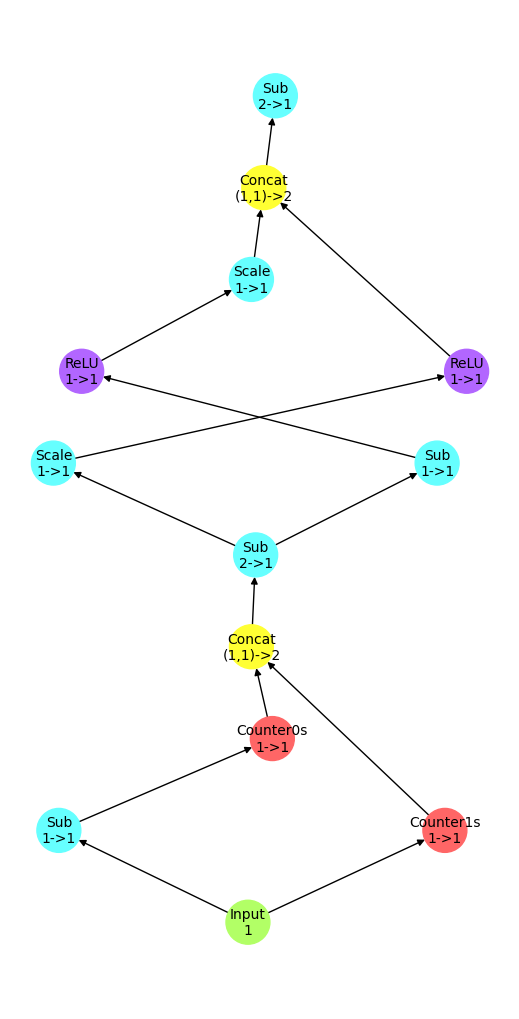

In [4]:
lsrl.utils.plot_and_save_graph(loop.graph(), figsize=(5,10))

Let's turn it into a single path graph.

    1. fold_state_after_linear ReLU: 2, Concat: 2, LinState: 2, Linear: 5, Input: 1 (Total: 12 nodes). MaxBranches: 2. Progress: 0/7
    2. before_debranching ReLU: 2, Concat: 2, LinState: 2, Linear: 5, Input: 1 (Total: 12 nodes). MaxBranches: 2. Progress: 0/7
    3. only_states ReLU: 2, Slice: 2, Concat: 2, LinState: 1, Linear: 5, Input: 1 (Total: 13 nodes). MaxBranches: 2. Progress: 1/8
    4. slice_into_next ReLU: 2, Concat: 2, LinState: 1, Linear: 6, Input: 1 (Total: 12 nodes). MaxBranches: 2. Progress: 4/8
    5. fold_concat_to_duplicate ReLU: 2, Concat: 1, LinState: 1, Linear: 7, Input: 1 (Total: 12 nodes). MaxBranches: 2. Progress: 4/8
    6. fold_conseq_linear ReLU: 2, Concat: 1, LinState: 1, Linear: 6, Input: 1 (Total: 11 nodes). MaxBranches: 2. Progress: 3/7
    7. fold_conseq_linear ReLU: 2, Concat: 1, LinState: 1, Linear: 5, Input: 1 (Total: 10 nodes). MaxBranches: 2. Progress: 2/6
    8. only_linear_nonslice ReLU: 2, Slice: 2, Concat: 1, LinState: 1, Linear: 4, Input: 1 (T

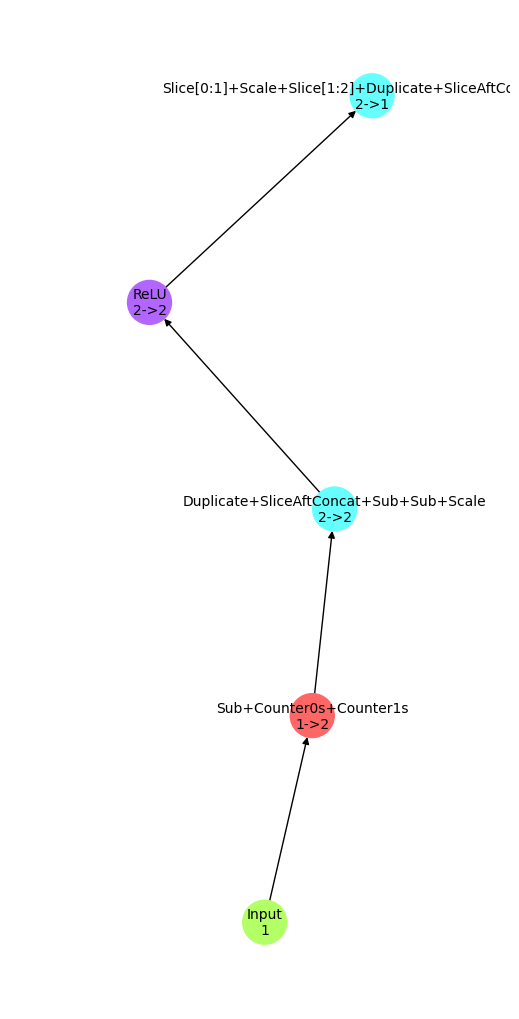

In [5]:
loop.simplify()
lsrl.utils.plot_and_save_graph(loop.graph(), figsize=(5,10))

Extract the underlying model:

In [6]:
for layer_idx, layer in enumerate(loop.topological_sort()):
    if isinstance(layer, lsrl.Input):
        print(f"{layer_idx+1:>2}. Input")
    elif isinstance(layer, lsrl.LinState):
        print(f"{layer_idx+1:>2}. Linear State")
        print("A:")
        print(layer.A.numpy())
        print("B:")
        print(layer.B.numpy())
        print("bias:")
        print(layer.bias.numpy())
        print("init_state:")
        print(layer.init_state.numpy())
    elif isinstance(layer, lsrl.Linear):
        print(f"{layer_idx+1:>2}. Linear")
        print("A:")
        print(layer.A.numpy())
        print("b:")
        print(layer.b.numpy())
    elif isinstance(layer, lsrl.ReLU):
        print(f"{layer_idx+1:>2}. ReLU")
    print()

 1. Input

 2. Linear State
A:
[[1. 0.]
 [0. 1.]]
B:
[[-1.]
 [ 1.]]
bias:
[[1.]
 [0.]]
init_state:
[[0.]
 [0.]]

 3. Linear
A:
[[   -1.     1.]
 [-1000.  1000.]]
b:
[[-0.001]
 [ 0.   ]]

 4. ReLU

 5. Linear
A:
[[-1000.     1.]]
b:
[[0.]]

